In [1]:
import pandas as pd
import ast
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score
import numpy as np
import re
import os
import pandas as pd
import re
import ast
import math
from wordfreq import word_frequency
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import glob

In [2]:

def parse_triples(triples_str):
    try:
        triples_list = ast.literal_eval(triples_str)
    except Exception as e:
        return set()
    
    seen = set()
    pattern = re.compile(r'<subj>(.*?)<rel>(.*?)<obj>(.*?)$')
    
    for triple in triples_list:
        match = pattern.search(triple)
        if match:
            s, p, o = match.groups()
            seen.add(s.strip().replace('_', ' '))
            seen.add(p.strip().replace('_', ' '))
            seen.add(o.strip().replace('_', ' '))
            
    return seen
def clean_text(text):
    if not isinstance(text, str): return str(text)
    text = text.split('Input Triple:')[0]
    text = text.split('\nInput Triple')[0]
    return text.strip()


In [3]:


def get_self_information(word):
    if word.lower() in ENGLISH_STOP_WORDS:
        return 0.0
    else:
        try:
            freq = word_frequency(word, 'en')
            if freq <= 0:
                return 20.0 # High penalty for OOV
            return -math.log2(freq)
        except:
            return 2.0

def calculate_residual_metric(text, entities):
    if not isinstance(text, str):
        return 0.0
    
    # Sort entities by length (descending) to handle substrings correctly
    sorted_entities = sorted(list(entities), key=len, reverse=True)
    
    residual_text = text
    # Remove entities
    for ent in sorted_entities:
        # Escape special characters in entity name for regex
        # Use IGNORECASE for matching
        pattern = re.escape(ent)
        residual_text = re.sub(pattern, '', residual_text, flags=re.IGNORECASE)
        
    # Clean up text: remove non-alphanumeric (except spaces) to isolate words
    # This removes punctuation left over
    words_text = re.sub(r'[^\w\s]', ' ', residual_text)
    words = words_text.split()
    
    total_info = 0.0
    for w in words:
        total_info += get_self_information(w)
        
    return total_info

def calculate(file_path, output_folder="processed_results/"):
    print(f"Processing: {file_path}")
    
    # Load data
    df = pd.read_csv(file_path)
    
    # Extract model name from filename
    filename = os.path.basename(file_path)
    # 移除 "gen_A_50" 和 ".csv"
    model_name = re.sub(".csv", '', filename)
    model_name = re.sub("gen_A_50_",'',model_name)
    
    # 1. Parse Entities
    if 'seen' not in df.columns:
        df['seen'] = df['triples'].apply(parse_triples)
    
    # 2. Calculate scores
    styles = ['academic', 'oral', 'twitter']
    stats = {'model_name': model_name}
    
    for style in styles:
        if style in df.columns:
            col_name = f'{style}_residual_info'
            # 计算每一行的 residual info
            df[col_name] = df.apply(
                lambda row: calculate_residual_metric(row[style], row['seen']), axis=1
            )
            
            # 记录统计值 (Mean & Median)
            stats[f'{style}_residual_mean'] = df[col_name].mean()
            stats[f'{style}_residual_median'] = df[col_name].median()
        else:
            # 如果列不存在，填 None 或 0
            stats[f'{style}_residual_mean'] = None
            stats[f'{style}_residual_median'] = None

    # Save individual scored file
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    output_path = os.path.join(output_folder, f"{model_name}_residual_info.csv")
    df.to_csv(output_path, index=False)
    
    return stats

folder = "original/" 
files = glob.glob(os.path.join(folder, "*CoT.csv"))

all_results = []

for file in files:
    try:
        result_stats = calculate(file)
        all_results.append(result_stats)
    except Exception as e:
        print(f"Error processing {file}: {e}")

all_results.append(result_stats)
# Create Evaluation Matrix DataFrame

if all_results:
    evl_matrix = pd.DataFrame(all_results)
    
    # 调整列顺序 (Optional)
    cols = ['model_name', 
            'academic_residual_mean',
            'academic_residual_median',
            'oral_residual_mean',
            'oral_residual_median',
            'twitter_residual_mean',
            'twitter_residual_median']
    # 确保只选择存在的列
    existing_cols = [c for c in cols if c in evl_matrix.columns]
    evl_matrix = evl_matrix[existing_cols]
    
    # Save final summary
    evl_matrix.to_csv("residual_matrix.csv", index=False)
    print(evl_matrix)
else:
    print("No results generated.")


Processing: original/gen_A_50_Llama-3.1-70B-Instruct-AWQ_CoT.csv
Processing: original/gen_A_50_Llama-3.3-70B-Instruct-AWQ_CoT.csv
Processing: original/gen_A_50_Llama-2-70B-AWQ_CoT.csv
                       model_name  academic_residual_mean  \
0  Llama-3.1-70B-Instruct-AWQ_CoT               54.332925   
1  Llama-3.3-70B-Instruct-AWQ_CoT              339.344410   
2             Llama-2-70B-AWQ_CoT               67.659729   
3             Llama-2-70B-AWQ_CoT               67.659729   

   academic_residual_median  oral_residual_mean  oral_residual_median  \
0                 30.660366           35.165578             17.075104   
1                372.495863          269.289543            261.952642   
2                 15.878483           98.170535             27.820303   
3                 15.878483           98.170535             27.820303   

   twitter_residual_mean  twitter_residual_median  
0              50.581391                40.832846  
1             185.192160               1

In [4]:

def calculate_coverage(text, entities):
    """
    Returns: float (0.0 到 1.0)
    """
    if not isinstance(text, str) or not entities:
        return 0.0

    text_lower = text.lower()
    text_clean = text_lower.replace('_', ' ')
    
    found_count = 0
    for ent in entities:
        if ent.lower() in text_clean:
            found_count += 1
    return found_count / len(entities)
def calculate(file_path, output_folder="processed_results/"):
    print(f"Processing: {file_path}")
    
    # Load data
    df = pd.read_csv(file_path)
    
    # Extract model name
    filename = os.path.basename(file_path)
    model_name = re.sub(".csv", '', filename)
    model_name= re.sub("gen_A_50_", '', model_name)
    if 'seen' not in df.columns:
        df['seen'] = df['triples'].apply(parse_triples)
    
    # 2. Calculate Coverage Scores
    styles = ['academic', 'oral', 'twitter']
    stats = {'model_name': model_name}
    
    for style in styles:
        if style in df.columns:
            col_name = f'{style}_coverage' 
            
            df[col_name] = df.apply(
                lambda row: calculate_coverage(row[style], row['seen']), axis=1
            )
            
            stats[f'{style}_coverage_mean'] = df[col_name].mean()
            stats[f'{style}_coverage_median'] = df[col_name].median()
        else:
            stats[f'{style}_coverage_mean'] = None
            stats[f'{style}_coverage_median'] = None

    # Save individual scored file
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    # 文件名也改为 coverage
    output_path = os.path.join(output_folder, f"{model_name}_coverage.csv")
    df.to_csv(output_path, index=False)
    
    return stats
# --- 3. 执行主循环 ---


folder = "original/"  # 输入文件夹路径
# 使用 glob 获取所有 csv 文件
files = glob.glob(os.path.join(folder, "*CoT.csv"))

# 如果 original 文件夹不存在或为空，且当前目录下有文件（仅用于测试）
if not files:
    print(f"Warning: No files found in {folder}. Checking current directory...")
    files = glob.glob("*.csv")
    folder = "./"

all_results = []

for file in files:
    try:
        result_stats = calculate(file)
        all_results.append(result_stats)
    except Exception as e:
        print(f"Error processing {file}: {e}")

# Create Evaluation Matrix DataFrame
if all_results:
    evl_matrix = pd.DataFrame(all_results)
    
    # 调整列顺序 (Optional)
    cols = ['model_name', 
            'academic_coverage_mean',
            'academic_coverage_median',
            'oral_coverage_mean',
            'oral_coverage_median',
            'twitter_coverage_mean',
            'twitter_coverage_median']
    # 确保只选择存在的列
    existing_cols = [c for c in cols if c in evl_matrix.columns]
    evl_matrix = evl_matrix[existing_cols]
    
    # Save final summary
    evl_matrix.to_csv("coverage_matrix.csv", index=False)
    print(evl_matrix)
else:
    print("No results generated.")


Processing: original/gen_A_50_Llama-3.1-70B-Instruct-AWQ_CoT.csv
Processing: original/gen_A_50_Llama-3.3-70B-Instruct-AWQ_CoT.csv
Processing: original/gen_A_50_Llama-2-70B-AWQ_CoT.csv
                       model_name  academic_coverage_mean  \
0  Llama-3.1-70B-Instruct-AWQ_CoT                0.813832   
1  Llama-3.3-70B-Instruct-AWQ_CoT                0.848738   
2             Llama-2-70B-AWQ_CoT                0.781653   

   academic_coverage_median  oral_coverage_mean  oral_coverage_median  \
0                  0.800000            0.833329              0.825758   
1                  0.857143            0.838579              0.866071   
2                  0.800000            0.694237              0.750000   

   twitter_coverage_mean  twitter_coverage_median  
0               0.800144                    0.800  
1               0.883843                    1.000  
2               0.721037                    0.775  


Llama-3.1-70B-Instruct-AWQ_three_shot
Llama-2-7B-chat_zero_shot
Llama-3.2-1B-Instruct_three_shot
Llama-2-70B-AWQ_zero_shot
Llama-3.2-1B_one_shot
Llama-3.3-70B-Instruct-AWQ_zero_shot
Llama-3.3-70B-Instruct-AWQ_three_shot
Llama-2-7B_three_shot
Llama-3.2-1B_three_shot
Llama-3.1-8B-Instruct_three_shot
Llama-3.2-3B_zero_shot
Llama-3.2-1B-Instruct_zero_shot
Llama-2-7B-chat_one_shot
Llama-3.2-3B-Instruct_zero_shot
Llama-3.3-70B-Instruct-AWQ_one_shot
Llama-2-13B-chat_zero_shot
Llama-3.2-3B-Instruct_three_shot
Llama-3.2-1B-Instruct_one_shot
Llama-3.1-8B_zero_shot
Llama-3.1-8B-Instruct_one_shot
Llama-2-13B-chat_one_shot
Llama-2-13B_one_shot
Llama-2-70B-AWQ_one_shot
Llama-3.2-1B_zero_shot
Llama-3.1-8B_three_shot
Llama-2-70B-AWQ_three_shot
Llama-2-7B-chat_three_shot
Llama-3.2-3B_three_shot
Llama-3.1-8B-Instruct_zero_shot
Llama-2-13B-chat_three_shot
Llama-2-7B_zero_shot
Llama-3.1-70B-Instruct-AWQ_zero_shot
Llama-3.1-8B_one_shot
Llama-2-13B_zero_shot
Llama-3.1-70B-Instruct-AWQ-_one_shot
Llama-3.2-3B

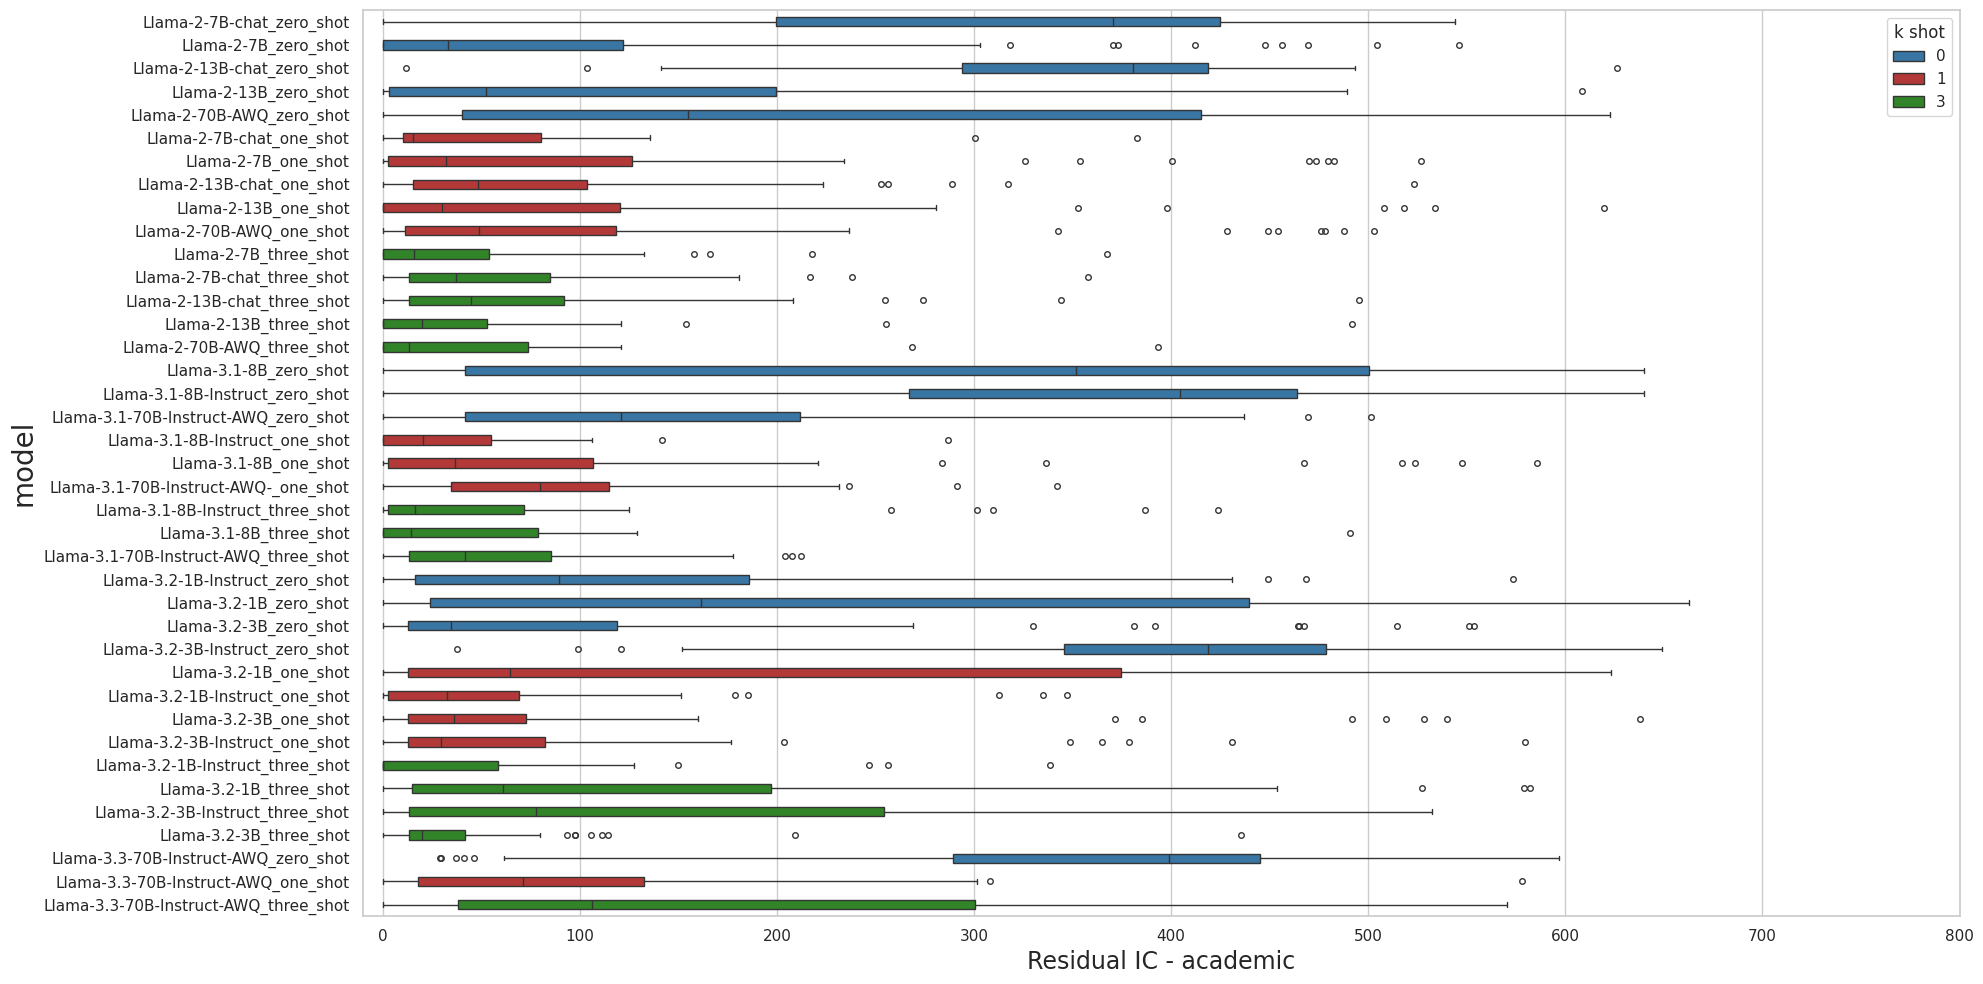

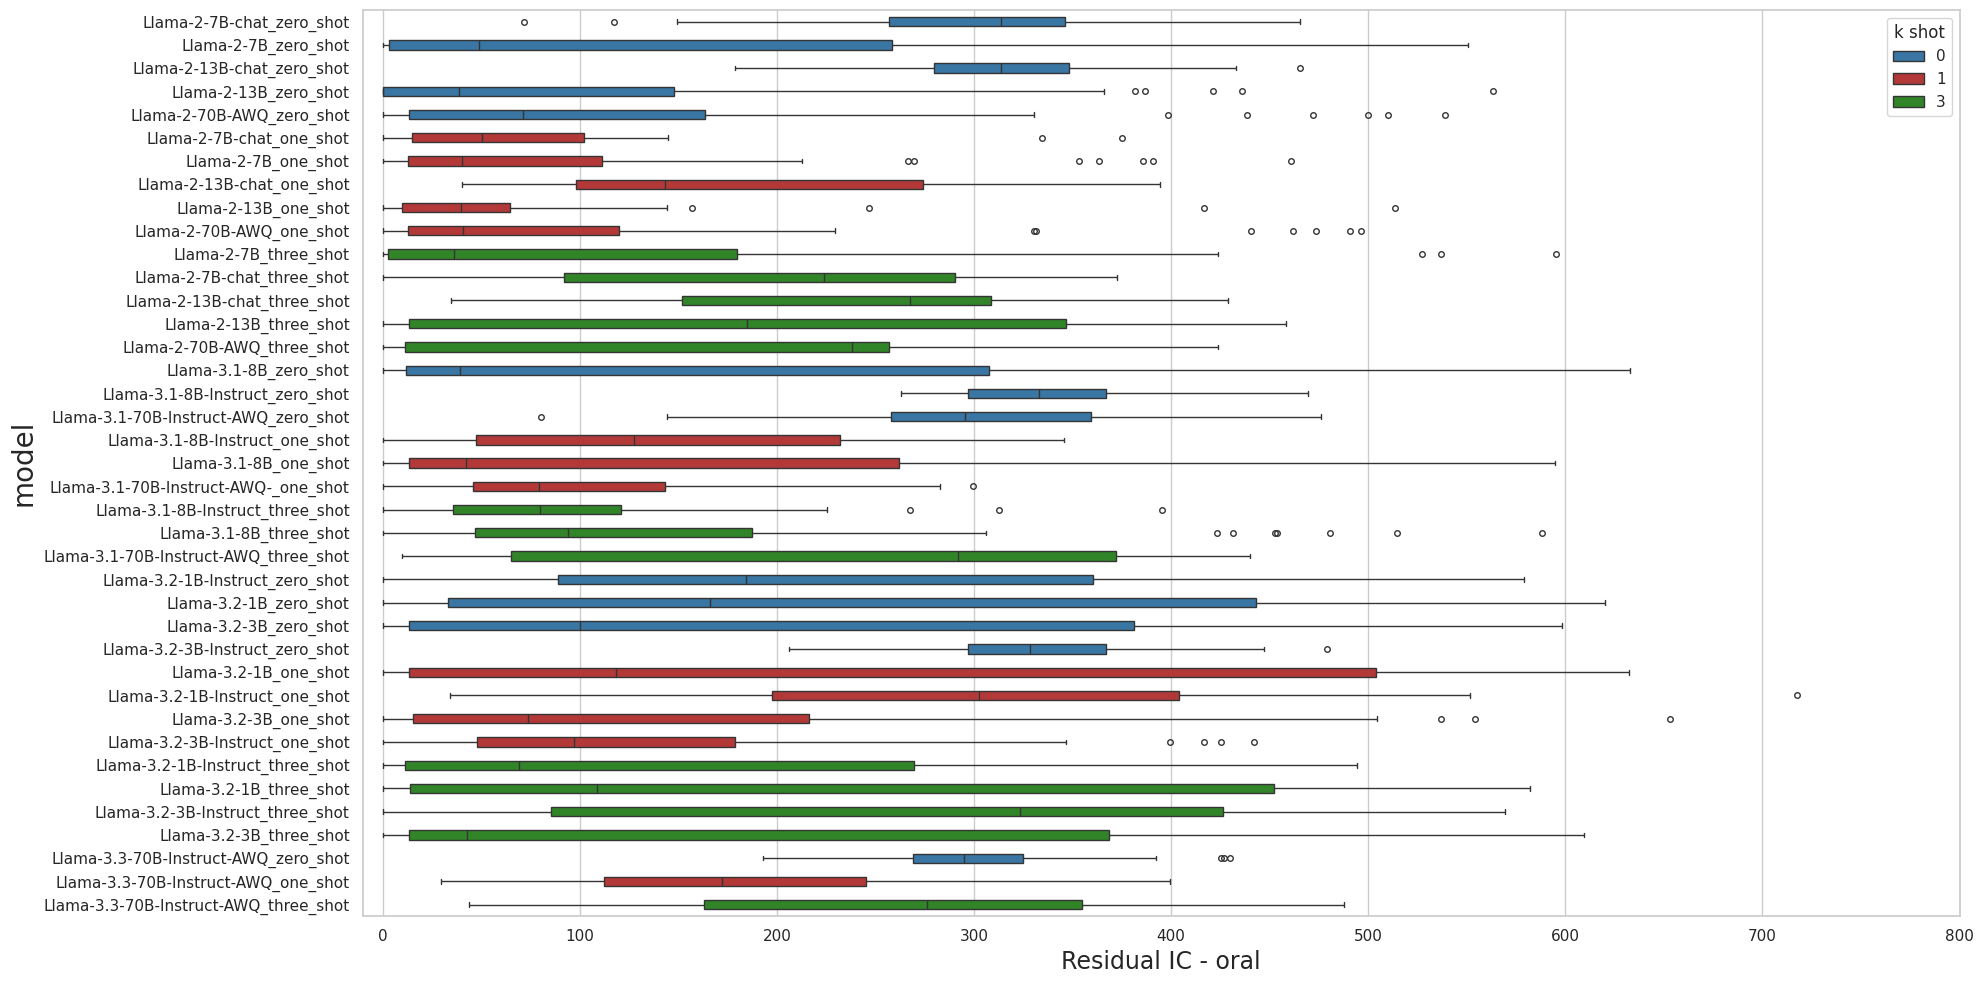

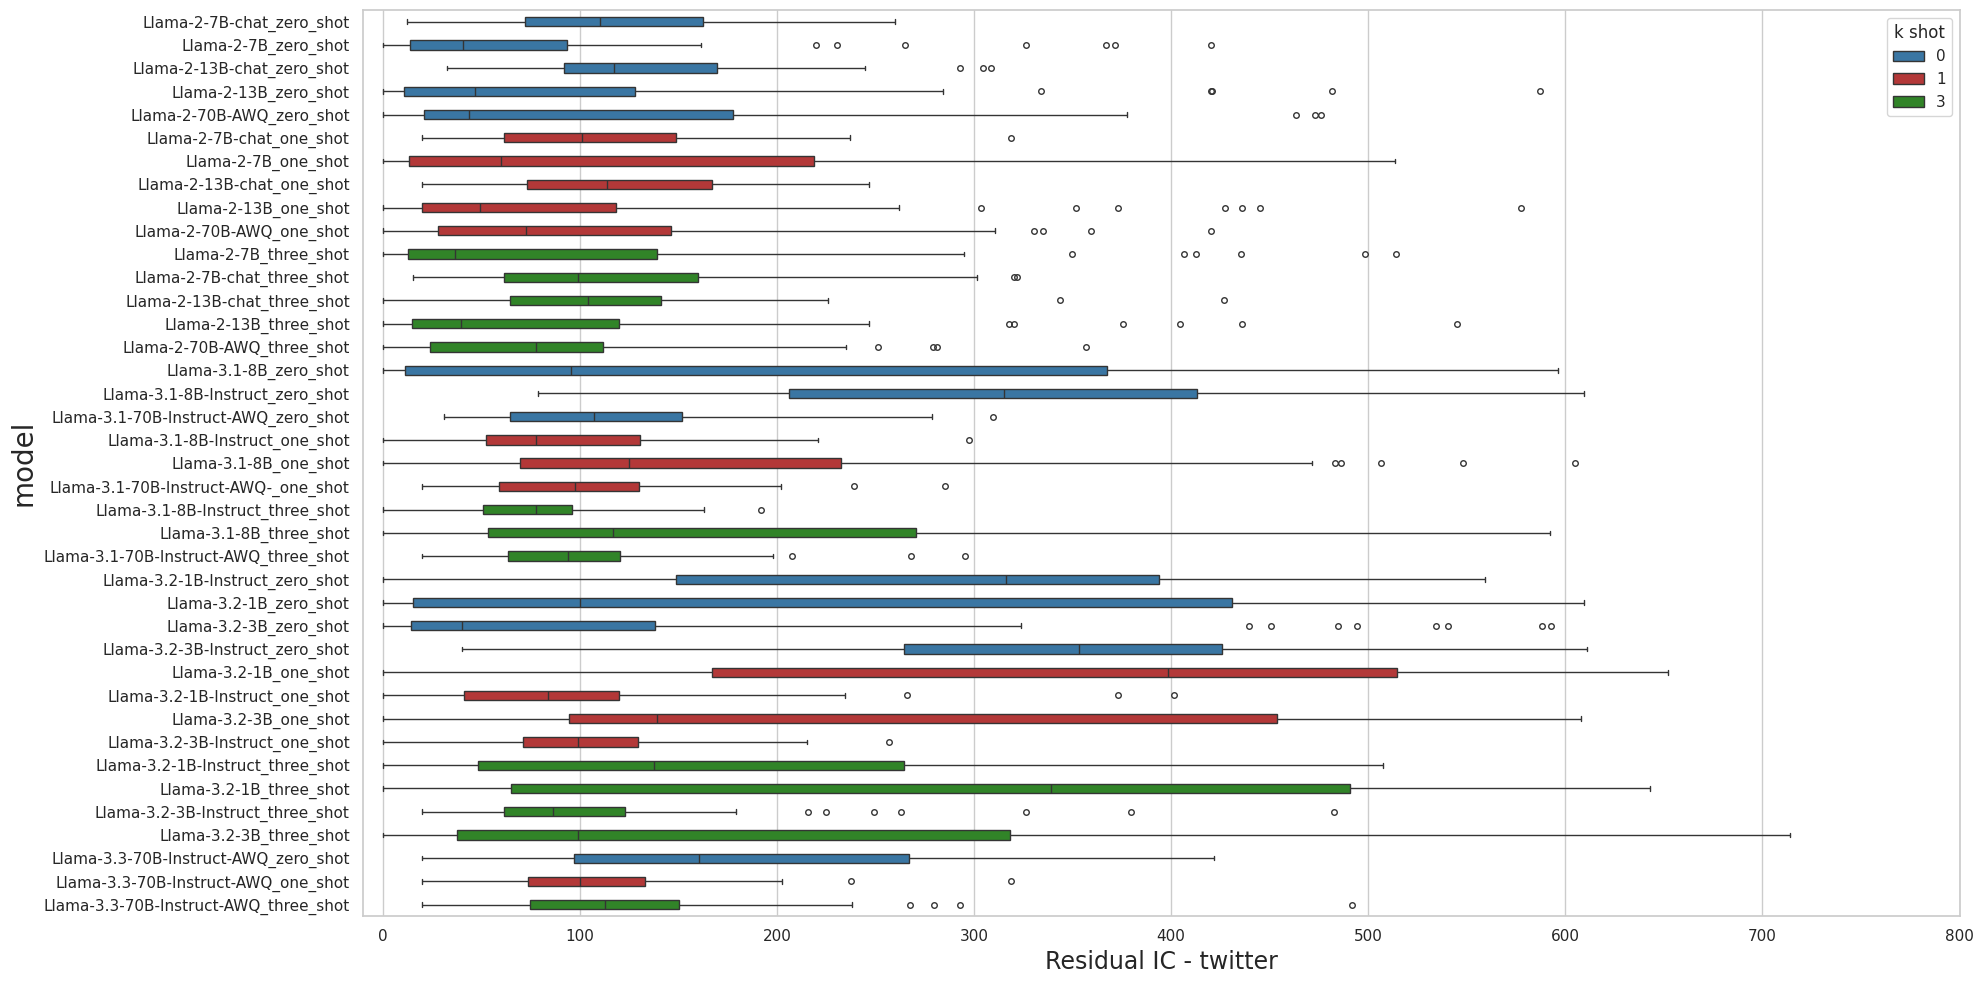

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
def f(style):
    FOLDER_PATH = 'processed_results'
    VALUE_COLUMN_NAME = str(style)+'_residual_info' 
    coverage_csv_files = glob.glob(os.path.join(FOLDER_PATH, "*residual_info.csv"))
    all_data=[]
    for file_path in coverage_csv_files:
        # Get filename without extension to use as the label

        file_name= os.path.basename(file_path)
        label_name = os.path.splitext(file_name)[0]
        label_name= re.sub("_residual_info",'',label_name)
        print(label_name)

        if "one_shot" in label_name:
            shot= 1
        elif "three_shot" in label_name:
            shot= 3
        else:
            shot = 0

        match = re.search(r'(\d+)B', label_name, re.IGNORECASE)
        if match:
            model_size = int(match.group(1)) 

        label = re.search(r"(Llama-\d+(?:\.\d+)?)", label_name, re.IGNORECASE)
        if label:
            label = label.group(1)
        
        try:
            # Read the CSV
            df = pd.read_csv(file_path)
            
            # Check if the target column exists
            if VALUE_COLUMN_NAME in df.columns:
                # extract the values and create a temporary dataframe
                temp_df = pd.DataFrame({
                    'Score': df[VALUE_COLUMN_NAME],
                    'Question Types': label_name,
                    'Label':label,
                    'k shot':shot,
                    'model_size': model_size
                })
                all_data.append(temp_df)
            else:
                print(f"Warning: Column '{VALUE_COLUMN_NAME}' not found in {file_name}")
                
        except Exception as e:
            print(f"Error reading {file_name}: {e}")


    final_df = pd.concat(all_data, ignore_index=True)
    final_df = final_df.sort_values(by=['Label','k shot','model_size'], ascending=[True, True,True])
    # sorted_order = [f"{label_name}_zero_shot_residual_info",f"{label_name}_one_shot_residual_info",f"{label_name}_three_shot_residual_info"]
    # # --- PLOTTING ---

    # Set the visual style to match the image (white background with grid)
    sns.set_theme(style="whitegrid")

    # Initialize the figure size
    plt.figure(figsize=(20, 10))

    # Create the Boxplot
    # orient='h' ensures it is horizontal
    sns.boxplot(
        data=final_df,
        x='Score',
        y='Question Types',

        hue='k shot',
        palette=["#2878B5", "#C82423", "#259319"],  # A standard matplotlib blue color
        width=0.4,        # Adjusts the width of the boxes
        fliersize=4       # Size of the diamond outliers
    )

    # Customizing Labels and Limits
    # plt.yticks([])
    plt.xlabel("Residual IC - "+style, fontsize=17)
    plt.ylabel("model", fontsize=20)
    plt.xlim(-10, 800) # Assuming scores are between 0 and 1

    # Tweak layout to prevent label clipping
    plt.tight_layout()

    # Show or Save
    #plt.show()
    plt.savefig(f'{style}_overview_residual_info.png',dpi=300) # Uncomment to save

for style in ["academic","oral","twitter"]:
    f(style)

Processing: Llama-2-70B-AWQ_CoT
Processing: Llama-2-70B-AWQ_zero_shot


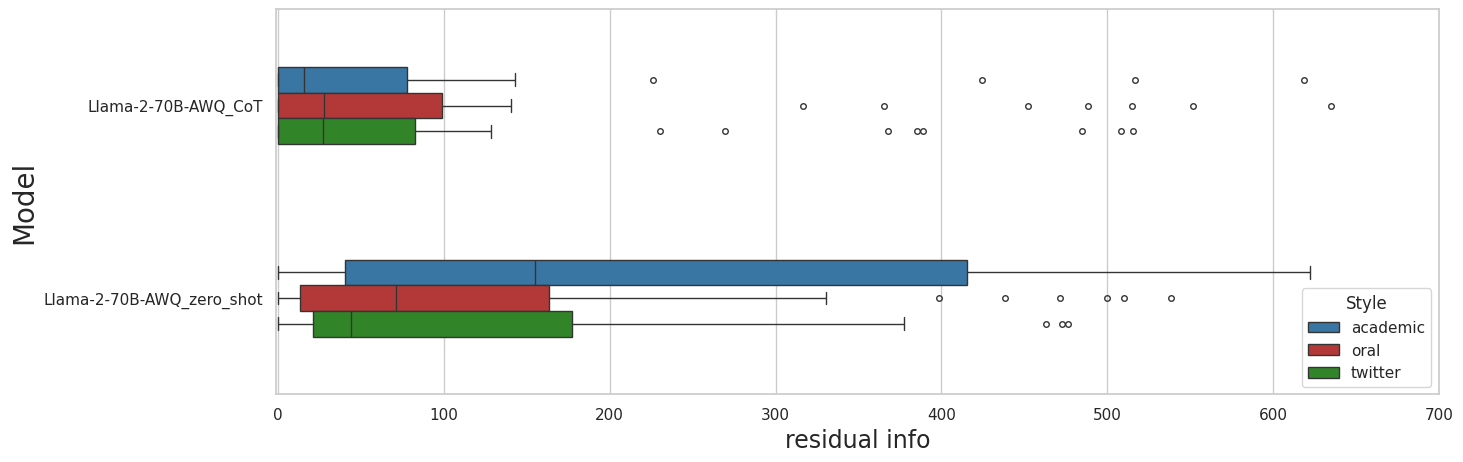

In [12]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import re

# 假设这是你的文件列表
model_name = "Llama-2-70B-AWQ"
coverage_csv_files = [f"processed_results/{model_name}_CoT_residual_info.csv", f"processed_results/{model_name}_zero_shot_residual_info.csv"]

all_data = []
# 定义你想画的那三列
target_columns = ["academic_residual_info", "oral_residual_info", "twitter_residual_info"]

for file_path in coverage_csv_files:
    # 1. 获取文件名作为 Label
    file_name = os.path.basename(file_path)
    label_name = os.path.splitext(file_name)[0]
    label_name = re.sub("_residual_info", '', label_name)
    print(f"Processing: {label_name}")

    try:
        # 2. 读取 CSV
        df = pd.read_csv(file_path)
        
        # 3. 检查列是否存在
        # (只要这三列都在，我们就处理)
        if set(target_columns).issubset(df.columns):
            
            # --- 核心修改：使用 melt 转换数据 ---
            # 这会将 3 列数值变成 2 列：'Style' (存放列名) 和 'Score' (存放数值)
            temp_df = df.melt(
                value_vars=target_columns,
                var_name='Style',  # 新的分类列名
                value_name='Score' # 新的数值列名
            )
            
            # 4. 添加模型标签
            temp_df['Question Types'] = label_name
            
            # 5. 清洗 Style 列的名字 (把 "_coverage" 去掉，让图例好看点)
            # 例如: "academic_coverage" -> "academic"
            temp_df['Style'] = temp_df['Style'].str.replace('_residual_info', '')
            
            all_data.append(temp_df)
            
        else:
            print(f"Warning: Missing target columns in {file_name}")
            
    except Exception as e:
        print(f"Error reading {file_name}: {e}")

# --- 合并数据并绘图 ---
if all_data:
    final_df = pd.concat(all_data, ignore_index=True)
    
    # 可选：按需排序
    final_df = final_df.sort_values(by=['Question Types', 'Style'])

    # 设置绘图风格
    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(15, 5))

    # 绘图
    sns.boxplot(
        data=final_df,
        x='Score',             # 数值
        y='Question Types',    # y轴：不同的模型/文件
        hue='Style',           # 颜色分组：academic/oral/twitter
        palette=["#2878B5", "#C82423", "#259319"], 
        width=0.4,             # 稍微调宽一点
        fliersize=4
    )

    plt.xlabel("residual info", fontsize=17)
    plt.ylabel("Model", fontsize=20)
    plt.xlim(-1, 700) 
    #plt.show()
    plt.savefig(f'CoT_{model_name}_residual_info.png',dpi=300)
else:
    print("No data loaded.")

Processing: Llama-2-7B-chat_zero_shot
Processing: Llama-2-7B_zero_shot


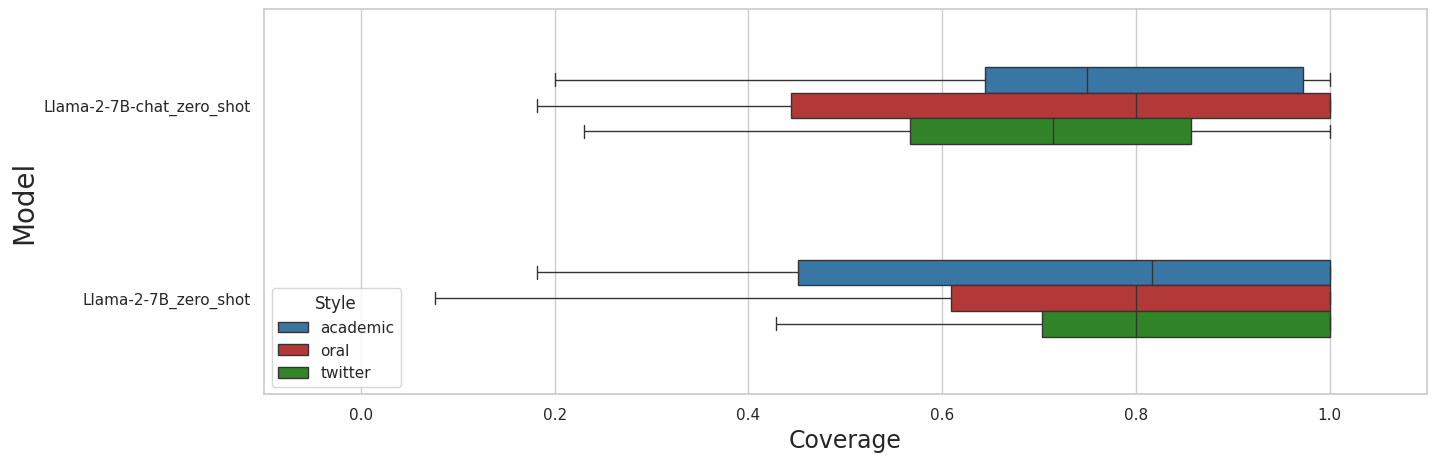

In [29]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import re

# 假设这是你的文件列表
filetype = "coverage"
coverage_csv_files = [f"processed_results/Llama-2-7B-chat_zero_shot_{filetype}.csv", f"processed_results/Llama-2-7B_zero_shot_{filetype}.csv"]

all_data = []
# 定义你想画的那三列
target_columns = [f"academic_{filetype}", f"oral_{filetype}", f"twitter_{filetype}"]

for file_path in coverage_csv_files:
    # 1. 获取文件名作为 Label
    file_name = os.path.basename(file_path)
    label_name = os.path.splitext(file_name)[0]
    label_name = re.sub(f"_{filetype}", '', label_name)
    print(f"Processing: {label_name}")

    try:
        # 2. 读取 CSV
        df = pd.read_csv(file_path)
        
        # 3. 检查列是否存在
        # (只要这三列都在，我们就处理)
        if set(target_columns).issubset(df.columns):
            
            # --- 核心修改：使用 melt 转换数据 ---
            # 这会将 3 列数值变成 2 列：'Style' (存放列名) 和 'Score' (存放数值)
            temp_df = df.melt(
                value_vars=target_columns,
                var_name='Style',  # 新的分类列名
                value_name='Score' # 新的数值列名
            )
            
            # 4. 添加模型标签
            temp_df['Question Types'] = label_name
            
            # 5. 清洗 Style 列的名字 (把 "_coverage" 去掉，让图例好看点)
            # 例如: "academic_coverage" -> "academic"
            temp_df['Style'] = temp_df['Style'].str.replace(f'_{filetype}', '')
            
            all_data.append(temp_df)
            
        else:
            print(f"Warning: Missing target columns in {file_name}")
            
    except Exception as e:
        print(f"Error reading {file_name}: {e}")

# --- 合并数据并绘图 ---
if all_data:
    final_df = pd.concat(all_data, ignore_index=True)
    
    # 可选：按需排序
    final_df = final_df.sort_values(by=['Question Types', 'Style'])

    # 设置绘图风格
    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(15, 5))

    # 绘图
    sns.boxplot(
        data=final_df,
        x='Score',             # 数值
        y='Question Types',    # y轴：不同的模型/文件
        hue='Style',           # 颜色分组：academic/oral/twitter
        palette=["#2878B5", "#C82423", "#259319"], 
        width=0.4,             # 稍微调宽一点
        fliersize=4
    )

    plt.xlabel(f"Coverage", fontsize=17)
    plt.ylabel("Model", fontsize=20)
    plt.xlim(-0.1, 1.1) 
    # plt.show()
    plt.savefig(f'chat_base_{filetype}.png',dpi=300)
else:
    print("No data loaded.")

Processing: Llama-2-7B
Processing: Llama-2-13B
Processing: Llama-2-70B-AWQ


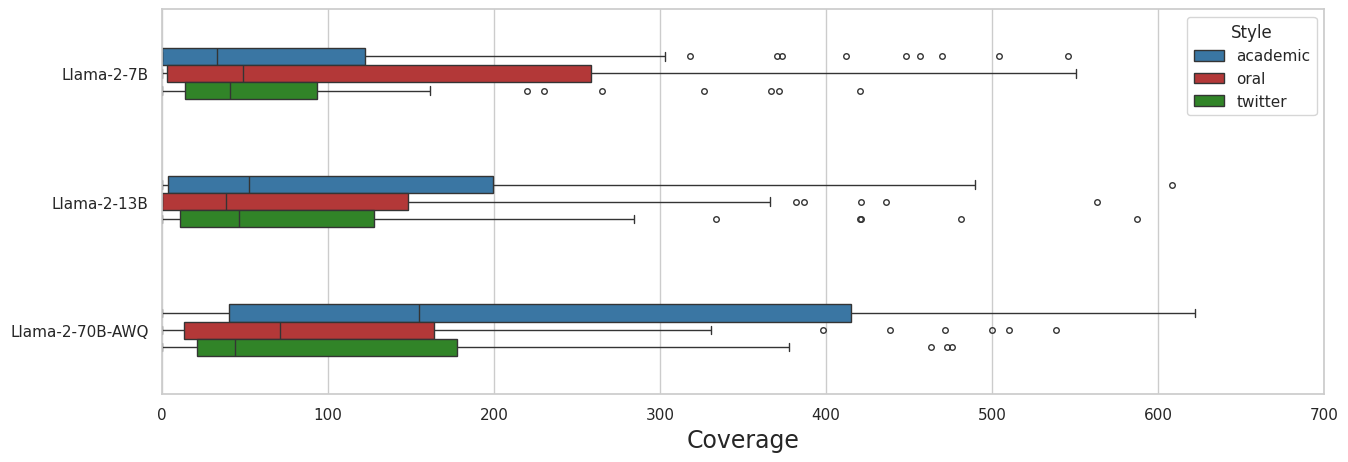

In [53]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import re

# 假设这是你的文件列表
filetype = "residual_info"
coverage_csv_files = [f"processed_results/Llama-2-7B_zero_shot_{filetype}.csv", f"processed_results/Llama-2-13B_zero_shot_{filetype}.csv",f"processed_results/Llama-2-70B-AWQ_zero_shot_{filetype}.csv"]

all_data = []
# 定义你想画的那三列
target_columns = [f"academic_{filetype}", f"oral_{filetype}", f"twitter_{filetype}"]

for file_path in coverage_csv_files:
    # 1. 获取文件名作为 Label
    file_name = os.path.basename(file_path)
    label_name = os.path.splitext(file_name)[0]
    label_name = re.sub(f"_zero_shot_{filetype}", '', label_name)
    print(f"Processing: {label_name}")

    try:
        # 2. 读取 CSV
        df = pd.read_csv(file_path)
        match = re.search(r'(\d+)B', label_name, re.IGNORECASE)
        if match:
            model_size = int(match.group(1)) 
        
        # 3. 检查列是否存在
        # (只要这三列都在，我们就处理)
        if set(target_columns).issubset(df.columns):
            
            # --- 核心修改：使用 melt 转换数据 ---
            # 这会将 3 列数值变成 2 列：'Style' (存放列名) 和 'Score' (存放数值)
            temp_df = df.melt(
                value_vars=target_columns,
                var_name='Style',  # 新的分类列名
                value_name='Score', # 新的数值列名
            )
            
            # 4. 添加模型标签
            temp_df['Question Types'] = label_name
            temp_df['size'] = model_size
            
            # 5. 清洗 Style 列的名字 (把 "_coverage" 去掉，让图例好看点)
            # 例如: "academic_coverage" -> "academic"
            temp_df['Style'] = temp_df['Style'].str.replace(f'_{filetype}', '')
            
            all_data.append(temp_df)
            
        else:
            print(f"Warning: Missing target columns in {file_name}")
            
    except Exception as e:
        print(f"Error reading {file_name}: {e}")

# --- 合并数据并绘图 ---
if all_data:
    final_df = pd.concat(all_data, ignore_index=True)
    
    # 可选：按需排序
    final_df = final_df.sort_values(by=['size', 'Style'])

    # 设置绘图风格
    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(15, 5))

    # 绘图
    sns.boxplot(
        data=final_df,
        x='Score',             # 数值
        y='Question Types',    # y轴：不同的模型/文件
        hue='Style',           # 颜色分组：academic/oral/twitter
        palette=["#2878B5", "#C82423", "#259319"], 
        width=0.4,             # 稍微调宽一点
        fliersize=4
    )

    plt.xlabel(f"Coverage", fontsize=17)
    plt.ylabel("", fontsize=20)
    plt.xlim(-0.1, 700) 
    #plt.show()
    plt.savefig(f'size_{filetype}.png',dpi=300)
else:
    print("No data loaded.")

In [39]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import glob
import re

# --- CONFIGURATION (MODIFY THESE) ---
# 1. Path to your folder containing the CSV files
FOLDER_PATH = 'processed_results' 

# 2. The name of the column in your CSVs that contains the numbers to plot
# (e.g., 'f1', 'score', 'accuracy', 'value')
VALUE_COLUMN_NAME = 'academic_residual_info' 

# 3. (Optional) Define the exact order of rows as seen in the image.
# If you leave this empty, the code will sort them alphabetically.
# ------------------------------------

def create_boxplot_from_folder():
    all_data = []

    # Get all csv files in the folder
    csv_files = glob.glob(os.path.join(FOLDER_PATH, "*.csv"))
    
    if not csv_files:
        print(f"No CSV files found in {FOLDER_PATH}")
        return

    print(f"Found {len(csv_files)} files. Processing...")

    for file_path in csv_files:
        # Get filename without extension to use as the label
        file_name = os.path.basename(file_path)
        label_name = os.path.splitext(file_name)[0]
        label_name= re.sub("_residual_info",'',label_name)
        print(label_name)

        try:
            # Read the CSV
            df = pd.read_csv(file_path)
            
            # Check if the target column exists
            if VALUE_COLUMN_NAME in df.columns:
                # extract the values and create a temporary dataframe
                temp_df = pd.DataFrame({
                    'Score': df[VALUE_COLUMN_NAME],
                    'Question Types': label_name
                })
                all_data.append(temp_df)
            else:
                print(f"Warning: Column '{VALUE_COLUMN_NAME}' not found in {file_name}")
                
        except Exception as e:
            print(f"Error reading {file_name}: {e}")

    # Combine all data into one large DataFrame
    if not all_data:
        print("No data extracted.")
        return

    final_df = pd.concat(all_data, ignore_index=True)

    # --- PLOTTING ---
    
    # Set the visual style to match the image (white background with grid)
    sns.set_theme(style="whitegrid")
    
    # Initialize the figure size
    plt.figure(figsize=(10, 6))

    # Create the Boxplot
    # orient='h' ensures it is horizontal
    sns.boxplot(
        data=final_df,
        x='Score',
        y='Question Types',
        color='#1f77b4',  # A standard matplotlib blue color
        width=0.6,        # Adjusts the width of the boxes
        fliersize=4       # Size of the diamond outliers
    )

    # Customizing Labels and Limits
    plt.xlabel("residual IC", fontsize=14)
    plt.ylabel("Model", fontsize=14)
    plt.xlim(-10, 1000) # Assuming scores are between 0 and 1
    
    # Tweak layout to prevent label clipping
    plt.tight_layout()
    
    # Show or Save
    plt.show()
    #plt.savefig('academic_residual_info.png',dpi=300) # Uncomment to save

if __name__ == "__main__":
    create_boxplot_from_folder()

Found 13 files. Processing...
Llama-2-13B-chat_coverage
Llama-2-7B_coverage
Llama-3.2-1B_coverage
Llama-3.2-3B_coverage
Llama-3.2-1B-Instruct_coverage
Llama-3.1-8B_coverage
Llama-2-70B-Chat-AWQ_coverage
Llama-3.1-70B-Instruct-AWQ_coverage
Llama-3.1-8B-Instruct_coverage
Llama-3.3-70B-Instruct-AWQ_coverage
Llama-2-13B_coverage
Llama-3.2-3B-Instruct_coverage
Llama-2-7B-chat_coverage
No data extracted.


Llama-2-7B-chat_zero_shot_residual_info
Llama-2-7B-chat_one_shot_residual_info
Llama-2-7B-chat_three_shot_residual_info
Llama-2-7B-chat_zero_shot_residual_info
Llama-2-7B-chat_one_shot_residual_info
Llama-2-7B-chat_three_shot_residual_info
Llama-2-7B-chat_zero_shot_residual_info
Llama-2-7B-chat_one_shot_residual_info
Llama-2-7B-chat_three_shot_residual_info


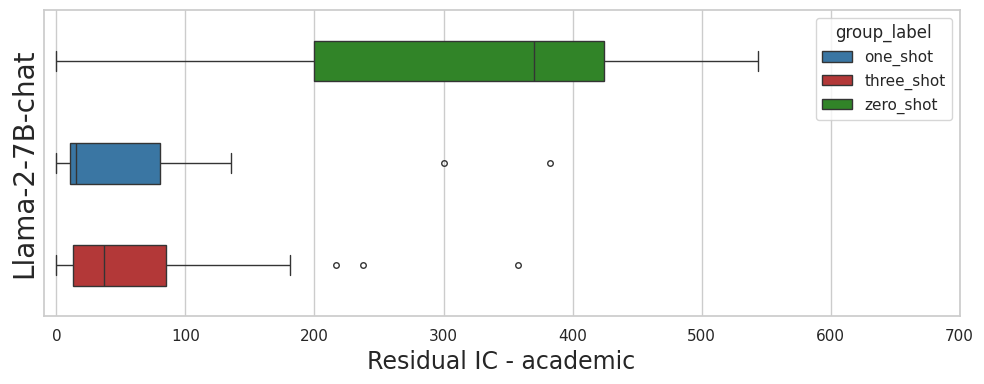

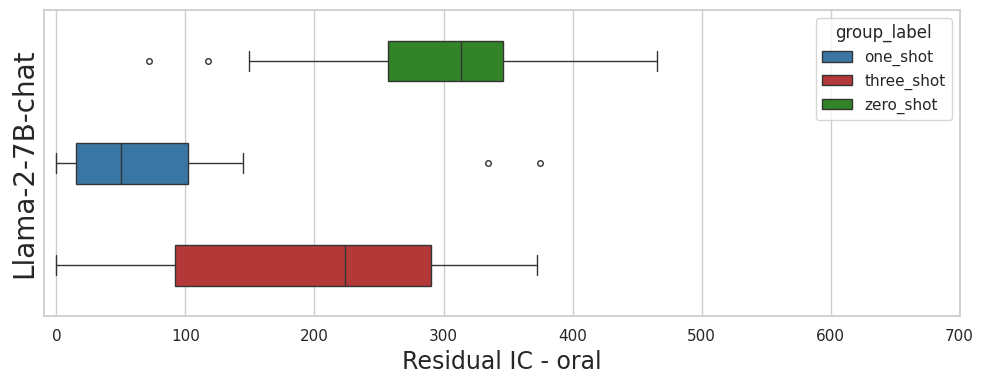

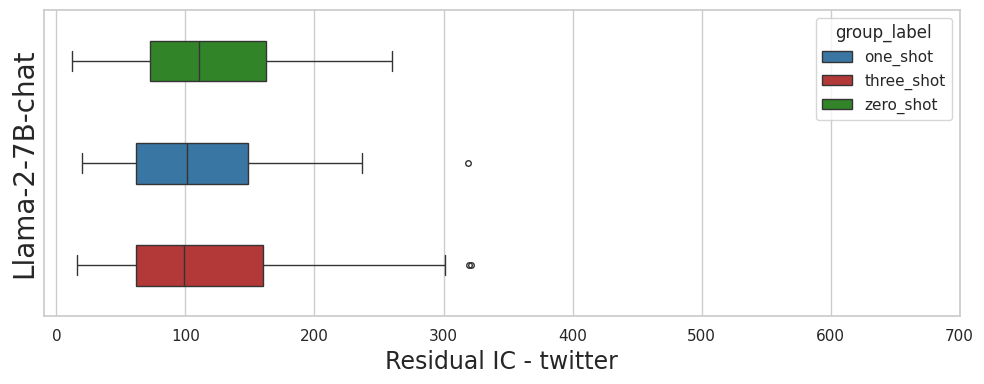

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
model="Llama-2-7B-chat"
def f(style):
    FOLDER_PATH = 'processed_results'
    VALUE_COLUMN_NAME = str(style)+'_residual_info' 
    coverage_csv_files = glob.glob(os.path.join(FOLDER_PATH, f"{model}_*residual_info.csv"))
    all_data=[]
    for file_path in coverage_csv_files:
        # Get filename without extension to use as the label

        file_name= os.path.basename(file_path)
        label_name = os.path.splitext(file_name)[0]
        label_name= re.sub("_coverage",'',label_name)
        print(label_name)

        if "one_shot" in label_name:
            shot= "one_shot"
        elif "three_shot" in label_name:
            shot= "three_shot"
        else:
            shot = "zero_shot"

        try:
            # Read the CSV
            df = pd.read_csv(file_path)
            
            # Check if the target column exists
            if VALUE_COLUMN_NAME in df.columns:
                # extract the values and create a temporary dataframe
                temp_df = pd.DataFrame({
                    'Score': df[VALUE_COLUMN_NAME],
                    'Question Types': label_name,
                    'group_label':shot
                })
                all_data.append(temp_df)
            else:
                print(f"Warning: Column '{VALUE_COLUMN_NAME}' not found in {file_name}")
                
        except Exception as e:
            print(f"Error reading {file_name}: {e}")


    final_df = pd.concat(all_data, ignore_index=True)
    final_df = final_df.sort_values(by=['group_label', 'Question Types'], ascending=[True, True])
    sorted_order = [f"{model}_zero_shot_residual_info",f"{model}_one_shot_residual_info",f"{model}_three_shot_residual_info"]

    # --- PLOTTING ---

    # Set the visual style to match the image (white background with grid)
    sns.set_theme(style="whitegrid")

    # Initialize the figure size
    plt.figure(figsize=(10, 4))

    # Create the Boxplot
    # orient='h' ensures it is horizontal
    sns.boxplot(
        data=final_df,
        x='Score',
        y='Question Types',
        order= sorted_order,
        hue='group_label',
        palette=["#2878B5", "#C82423", "#259319"],  # A standard matplotlib blue color
        width=0.4,        # Adjusts the width of the boxes
        fliersize=4       # Size of the diamond outliers
    )

    # Customizing Labels and Limits
    plt.yticks([])
    plt.xlabel("Residual IC - "+style, fontsize=17)
    plt.ylabel(model, fontsize=20)
    plt.xlim(-10, 700) # Assuming scores are between 0 and 1

    # Tweak layout to prevent label clipping
    plt.tight_layout()

    # Show or Save
    #plt.show()
    plt.savefig(f'{style}_{model}_shots_residual_info.png',dpi=300) # Uncomment to save

for style in ["academic","oral","twitter"]:
    f(style)

Llama-2-7B-chat_three_shot_coverage
Llama-2-7B-chat_zero_shot_coverage
Llama-2-7B-chat_one_shot_coverage
Llama-2-7B-chat_three_shot_coverage
Llama-2-7B-chat_zero_shot_coverage
Llama-2-7B-chat_one_shot_coverage
Llama-2-7B-chat_three_shot_coverage
Llama-2-7B-chat_zero_shot_coverage
Llama-2-7B-chat_one_shot_coverage


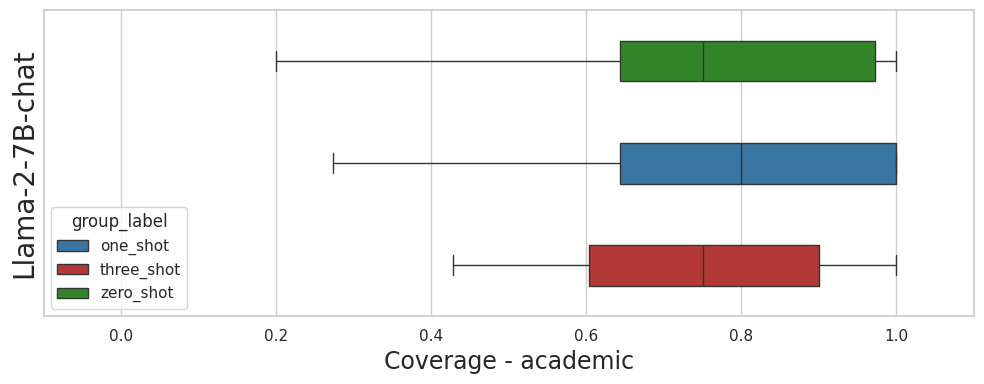

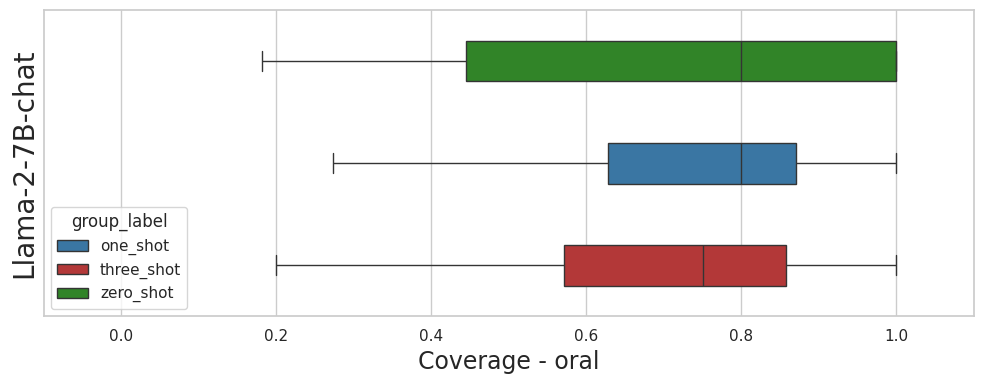

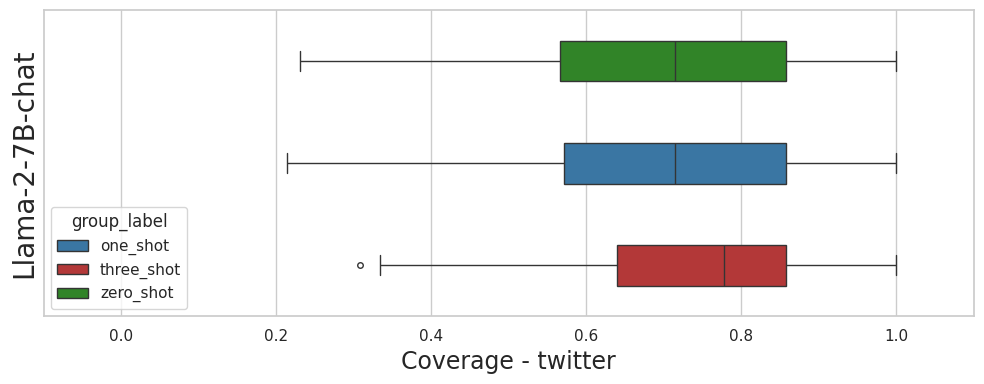

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
model="Llama-2-7B-chat"
def f(style):
    FOLDER_PATH = 'processed_results'
    VALUE_COLUMN_NAME = str(style)+'_coverage' 
    coverage_csv_files = glob.glob(os.path.join(FOLDER_PATH, f"{model}_*coverage.csv"))
    all_data=[]
    for file_path in coverage_csv_files:
        # Get filename without extension to use as the label

        file_name= os.path.basename(file_path)
        label_name = os.path.splitext(file_name)[0]
        print(label_name)

        if "one_shot" in label_name:
            shot= "one_shot"
        elif "three_shot" in label_name:
            shot= "three_shot"
        else:
            shot = "zero_shot"

        try:
            # Read the CSV
            df = pd.read_csv(file_path)
            
            # Check if the target column exists
            if VALUE_COLUMN_NAME in df.columns:
                # extract the values and create a temporary dataframe
                temp_df = pd.DataFrame({
                    'Score': df[VALUE_COLUMN_NAME],
                    'Question Types': label_name,
                    'group_label':shot
                })
                all_data.append(temp_df)
            else:
                print(f"Warning: Column '{VALUE_COLUMN_NAME}' not found in {file_name}")
                
        except Exception as e:
            print(f"Error reading {file_name}: {e}")


    final_df = pd.concat(all_data, ignore_index=True)
    final_df = final_df.sort_values(by=['group_label', 'Question Types'], ascending=[True, True])
    sorted_order = [f"{model}_zero_shot_coverage",f"{model}_one_shot_coverage",f"{model}_three_shot_coverage"]

    # --- PLOTTING ---

    # Set the visual style to match the image (white background with grid)
    sns.set_theme(style="whitegrid")

    # Initialize the figure size
    plt.figure(figsize=(10, 4))

    # Create the Boxplot
    # orient='h' ensures it is horizontal
    sns.boxplot(
        data=final_df,
        x='Score',
        y='Question Types',
        order= sorted_order,
        hue='group_label',
        palette=["#2878B5", "#C82423", "#259319"],  # A standard matplotlib blue color
        width=0.4,        # Adjusts the width of the boxes
        fliersize=4       # Size of the diamond outliers
    )

    # Customizing Labels and Limits
    plt.yticks([])
    plt.xlabel("Coverage - "+style, fontsize=17)
    plt.ylabel(f"{model}", fontsize=20)
    plt.xlim(-0.1, 1.1) # Assuming scores are between 0 and 1

    # Tweak layout to prevent label clipping
    plt.tight_layout()

    # Show or Save
    #plt.show()
    plt.savefig(f'{style}_{model}_shots_coverage.png',dpi=300) # Uncomment to save

for style in ["academic","oral","twitter"]:
    f(style)

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt

def f(style):
    FOLDER_PATH = 'processed_results'
    VALUE_COLUMN_NAME = str(style)+'_coverage' 
    coverage_csv_files = ["processed_results/Llama-2-7B_zero_shot_","Llama-2-13B","Llama-2-70B"]
    all_data=[]
    for file_path in coverage_csv_files:
        # Get filename without extension to use as the label

        file_name= os.path.basename(file_path)
        label_name = os.path.splitext(file_name)[0]
        print(label_name)

    #     try:
    #         # Read the CSV
    #         df = pd.read_csv(file_path)
            
    #         # Check if the target column exists
    #         if VALUE_COLUMN_NAME in df.columns:
    #             # extract the values and create a temporary dataframe
    #             temp_df = pd.DataFrame({
    #                 'Score': df[VALUE_COLUMN_NAME],
    #                 'Question Types': label_name,
    #                 # 'group_label':shot
    #             })
    #             all_data.append(temp_df)
    #         else:
    #             print(f"Warning: Column '{VALUE_COLUMN_NAME}' not found in {file_name}")
                
    #     except Exception as e:
    #         print(f"Error reading {file_name}: {e}")


    # final_df = pd.concat(all_data, ignore_index=True)
    # final_df = final_df.sort_values(by=[ 'Score','Question Types'], ascending=[True, True])
    # sorted_order = ["Llama-2-7B-chat_coverage","Llama-2-13B-chat_coverage","Llama-2-70B-Chat-AWQ_coverage"]

    # # --- PLOTTING ---

    # # Set the visual style to match the image (white background with grid)
    # sns.set_theme(style="whitegrid")

    # # Initialize the figure size
    # plt.figure(figsize=(10, 4))

    # # Create the Boxplot
    # # orient='h' ensures it is horizontal
    # ax=sns.boxplot(
    #     data=final_df,
    #     x='Score',
    #     y='Question Types',
    #     order= sorted_order,
    #     # hue='group_label',
    #     palette=["#2878B5"],  # A standard matplotlib blue color
    #     width=0.4,        # Adjusts the width of the boxes
    #     fliersize=4       # Size of the diamond outliers
    # )

    # # Customizing Labels and Limits
    # # plt.yticks([])
    # plt.xlabel("Coverage - "+style, fontsize=17)
    # plt.ylabel("", fontsize=20)
    # plt.xlim(-0.1, 1.1) # Assuming scores are between 0 and 1

    # # Tweak layout to prevent label clipping
    # # plt.tight_layout()
    # new_labels = ["7B", "13B", "70B"] 

    # # 3. 设置 Y 轴刻度标签
    # ax.set_yticklabels(new_labels)
    # # Show or Save
    # #plt.show()
    # plt.savefig(f'{style}_size_coverage.png',dpi=300) # Uncomment to save

for style in ["academic","oral","twitter"]:
    f(style)

Llama-2-13B-chat_zero_shot_coverage
Llama-2-7B-chat_zero_shot_coverage
Llama-2-13B-chat_zero_shot_coverage
Llama-2-7B-chat_zero_shot_coverage
Llama-2-13B-chat_zero_shot_coverage
Llama-2-7B-chat_zero_shot_coverage


Llama-2-13B-chat_residual_info
Llama-2-7B-chat_residual_info
Llama-2-70B-Chat-AWQ_residual_info


/tmp/ipykernel_3744219/424422698.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax=sns.boxplot(
/tmp/ipykernel_3744219/424422698.py:50: UserWarning: 
The palette list has fewer values (1) than needed (3) and will cycle, which may produce an uninterpretable plot.
  ax=sns.boxplot(
/tmp/ipykernel_3744219/424422698.py:72: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(new_labels)


Llama-2-13B-chat_residual_info
Llama-2-7B-chat_residual_info
Llama-2-70B-Chat-AWQ_residual_info


/tmp/ipykernel_3744219/424422698.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax=sns.boxplot(
/tmp/ipykernel_3744219/424422698.py:50: UserWarning: 
The palette list has fewer values (1) than needed (3) and will cycle, which may produce an uninterpretable plot.
  ax=sns.boxplot(
/tmp/ipykernel_3744219/424422698.py:72: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(new_labels)


Llama-2-13B-chat_residual_info
Llama-2-7B-chat_residual_info
Llama-2-70B-Chat-AWQ_residual_info


/tmp/ipykernel_3744219/424422698.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax=sns.boxplot(
/tmp/ipykernel_3744219/424422698.py:50: UserWarning: 
The palette list has fewer values (1) than needed (3) and will cycle, which may produce an uninterpretable plot.
  ax=sns.boxplot(
/tmp/ipykernel_3744219/424422698.py:72: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(new_labels)


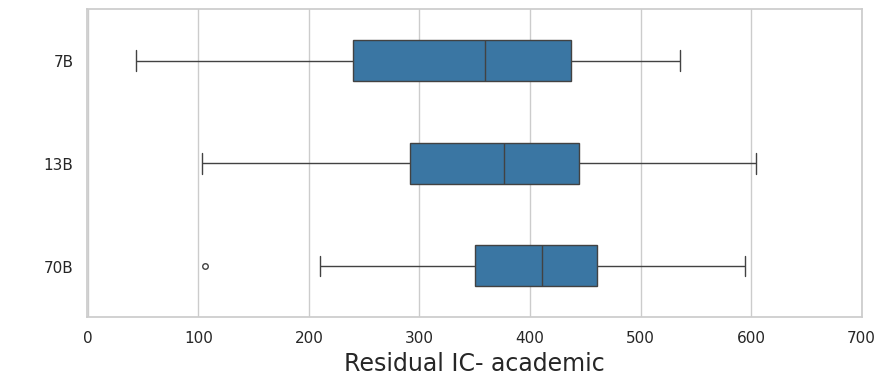

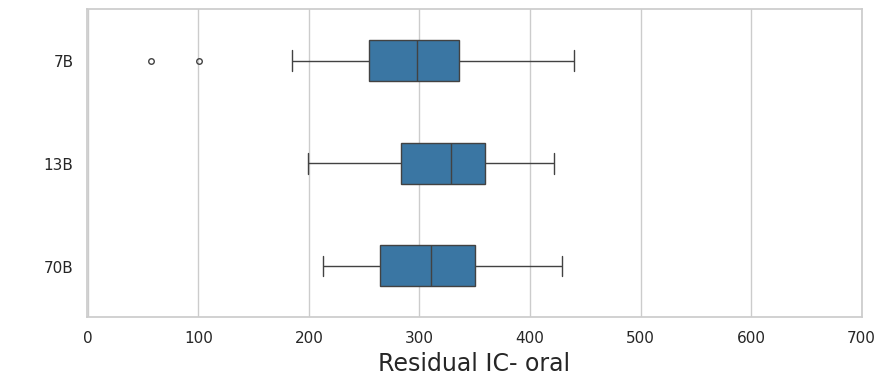

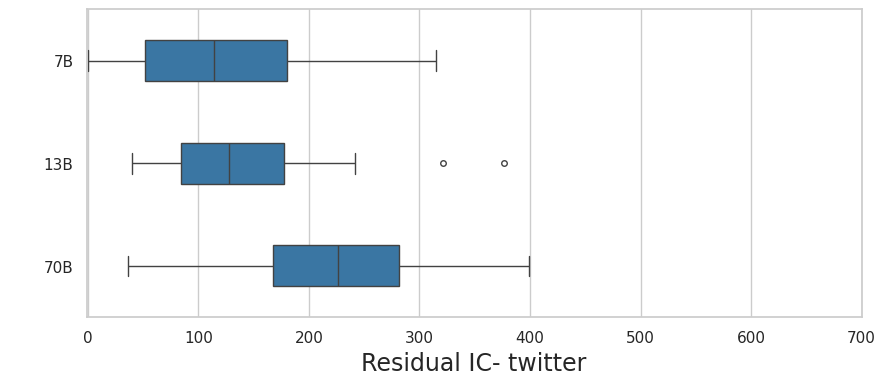

In [58]:
import seaborn as sns
import matplotlib.pyplot as plt

def f(style):
    FOLDER_PATH = 'processed_results'
    VALUE_COLUMN_NAME = str(style)+'_residual_info' 
    coverage_csv_files = ["processed_results/Llama-2-13B-chat_residual_info.csv","processed_results/Llama-2-7B-chat_residual_info.csv","processed_results/Llama-2-70B-Chat-AWQ_residual_info.csv"]
    all_data=[]
    for file_path in coverage_csv_files:
        # Get filename without extension to use as the label

        file_name= os.path.basename(file_path)
        label_name = os.path.splitext(file_name)[0]
        print(label_name)

        try:
            # Read the CSV
            df = pd.read_csv(file_path)
            
            # Check if the target column exists
            if VALUE_COLUMN_NAME in df.columns:
                # extract the values and create a temporary dataframe
                temp_df = pd.DataFrame({
                    'Score': df[VALUE_COLUMN_NAME],
                    'Question Types': label_name,
                    # 'group_label':shot
                })
                all_data.append(temp_df)
            else:
                print(f"Warning: Column '{VALUE_COLUMN_NAME}' not found in {file_name}")
                
        except Exception as e:
            print(f"Error reading {file_name}: {e}")


    final_df = pd.concat(all_data, ignore_index=True)
    final_df = final_df.sort_values(by=[ 'Score','Question Types'], ascending=[True, True])
    sorted_order = ["Llama-2-7B-chat_residual_info","Llama-2-13B-chat_residual_info","Llama-2-70B-Chat-AWQ_residual_info"]

    # --- PLOTTING ---

    # Set the visual style to match the image (white background with grid)
    sns.set_theme(style="whitegrid")

    # Initialize the figure size
    plt.figure(figsize=(10, 4))

    # Create the Boxplot
    # orient='h' ensures it is horizontal
    ax=sns.boxplot(
        data=final_df,
        x='Score',
        y='Question Types',
        order= sorted_order,
        # hue='group_label',
        palette=["#2878B5"],  # A standard matplotlib blue color
        width=0.4,        # Adjusts the width of the boxes
        fliersize=4       # Size of the diamond outliers
    )

    # Customizing Labels and Limits
    # plt.yticks([])
    plt.xlabel("Residual IC- "+style, fontsize=17)
    plt.ylabel(" ", fontsize=20)
    plt.xlim(-1, 700) # Assuming scores are between 0 and 1

    # Tweak layout to prevent label clipping
    # plt.tight_layout()
    new_labels = ["7B", "13B", "70B"] 

    # 3. 设置 Y 轴刻度标签
    ax.set_yticklabels(new_labels)
    # Show or Save
    #plt.show()
    plt.savefig(f'{style}_size_IC.png',dpi=300) # Uncomment to save

for style in ["academic","oral","twitter"]:
    f(style)

In [43]:
re.findall(r"\d+B",label_name)

['70B']

Found 39 files. Processing...
Llama-3.1-8B-Instruct_one_shot
Llama-2-7B_three_shot
Llama-2-13B-chat
Llama-2-13B-chat_one_shot
Llama-2-7B
Llama-3.2-3B-Instruct_three_shot
Llama-3.2-1B
Llama-2-13B_one_shot
Llama-3.2-3B
Llama-3.3-70B-Instruct-awq_one_shot
Llama-3.1-8B-Instruct_three_shot
Llama-2-13B_three_shot
Llama-3.2-1B-Instruct
Llama-3.1-8B
Llama-2-70B-AWQ_one_shot
Llama-3.2-1B_three_shot
Llama-2-70B-Chat-AWQ
Llama-3.3-70B-Instruct-awq_three_shot
Llama-3.1-70B-Instruct-AWQ
Llama-3.1-8B-Instruct
Llama-3.1-70B-Instruct-awq_one_shot
Llama-3.2-3B_three_shot
Llama-3.2-3B_one_shot
Llama-2-7B-chat_three_shot
Llama-2-13B-chat_three_shot
Llama-3.1-8B_one_shot
Llama-3.3-70B-Instruct-AWQ
Llama-2-13B
Llama-3.2-1B-Instruct_one_shot
Llama-3.2-1B-Instruct_three_shot
Llama-3.2-3B-Instruct_one_shot
Llama-2-7B_one_shot
Llama-3.2-3B-Instruct
Llama-3.2-1B_one_shot
Llama-3.1-70B-Instruct-awq_three_shot
Llama-2-70B-AWQ_three_shot
Llama-3.1-8B_three_shot
Llama-2-7B-chat
Llama-2-7B-chat_one_shot


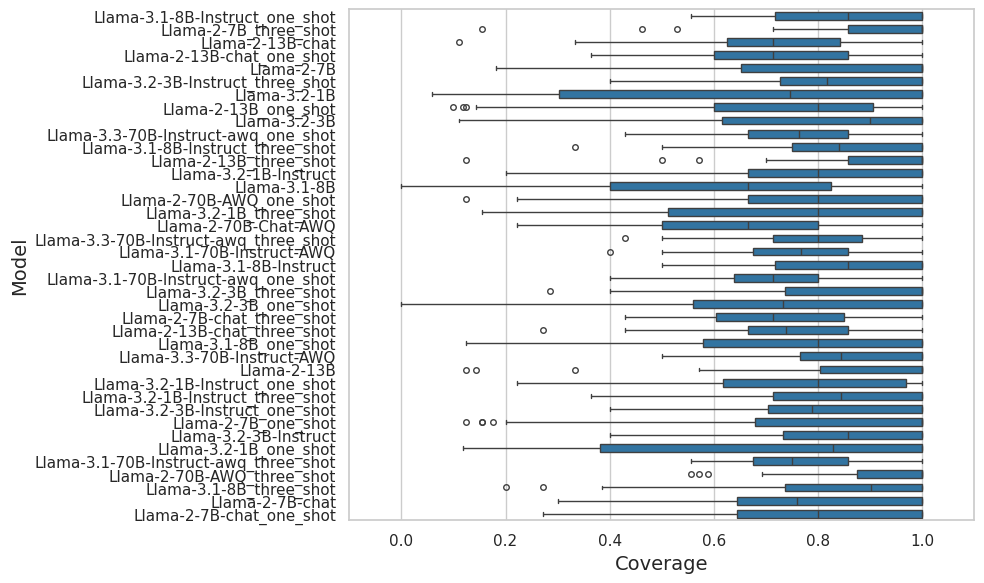

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import glob
import re

# --- CONFIGURATION (MODIFY THESE) ---
# 1. Path to your folder containing the CSV files
FOLDER_PATH = 'processed_results' 

# 2. The name of the column in your CSVs that contains the numbers to plot
# (e.g., 'f1', 'score', 'accuracy', 'value')
VALUE_COLUMN_NAME = 'academic_coverage' 

# 3. (Optional) Define the exact order of rows as seen in the image.
# If you leave this empty, the code will sort them alphabetically.
# ------------------------------------

def create_boxplot_from_folder():
    all_data = []

    # Get all csv files in the folder
    csv_files = glob.glob(os.path.join(FOLDER_PATH, "Llama-2*chat*coverage.csv"))
    
    if not csv_files:
        print(f"No CSV files found in {FOLDER_PATH}")
        return

    print(f"Found {len(csv_files)} files. Processing...")

    for file_path in csv_files:
        # Get filename without extension to use as the label
        file_name = os.path.basename(file_path)
        label_name = os.path.splitext(file_name)[0]
        label_name= re.sub("_coverage",'',label_name)
        print(label_name)

        try:
            # Read the CSV
            df = pd.read_csv(file_path)
            
            # Check if the target column exists
            if VALUE_COLUMN_NAME in df.columns:
                # extract the values and create a temporary dataframe
                temp_df = pd.DataFrame({
                    'Score': df[VALUE_COLUMN_NAME],
                    'Question Types': label_name
                })
                all_data.append(temp_df)
            else:
                print(f"Warning: Column '{VALUE_COLUMN_NAME}' not found in {file_name}")
                
        except Exception as e:
            print(f"Error reading {file_name}: {e}")

    # Combine all data into one large DataFrame
    if not all_data:
        print("No data extracted.")
        return

    final_df = pd.concat(all_data, ignore_index=True)

    # --- PLOTTING ---
    
    # Set the visual style to match the image (white background with grid)
    sns.set_theme(style="whitegrid")
    
    # Initialize the figure size
    plt.figure(figsize=(10, 6))

    # Create the Boxplot
    # orient='h' ensures it is horizontal
    sns.boxplot(
        data=final_df,
        x='Score',
        y='Question Types',
        color='#1f77b4',  # A standard matplotlib blue color
        width=0.6,        # Adjusts the width of the boxes
        fliersize=4       # Size of the diamond outliers
    )

    # Customizing Labels and Limits
    plt.xlabel("Coverage", fontsize=14)
    plt.ylabel("Model", fontsize=14)
    plt.xlim(-0.1, 1.1) # Assuming scores are between 0 and 1
    
    # Tweak layout to prevent label clipping
    plt.tight_layout()
    
    # Show or Save
    #plt.show()
    plt.savefig('academic_coverage.png',dpi=300) # Uncomment to save

if __name__ == "__main__":
    create_boxplot_from_folder()

Found 13 files. Processing...
Llama-3.3-70B-Instruct-AWQ
Llama-3.2-1B-Instruct
Llama-3.1-8B-Instruct
Llama-2-7B
Llama-3.1-70B-Instruct-AWQ
Llama-2-7B-chat
Llama-3.2-3B
Llama-2-13B
Llama-3.1-8B
Llama-3.2-1B
Llama-2-70B-Chat-AWQ
Llama-2-13B-chat
Llama-3.2-3B-Instruct


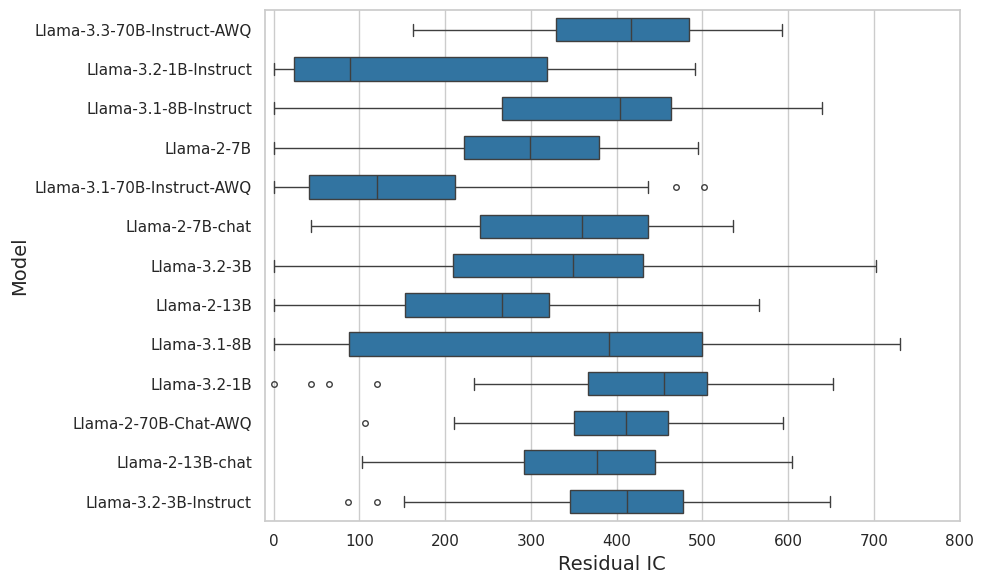

In [58]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import glob
import re

# --- CONFIGURATION (MODIFY THESE) ---
# 1. Path to your folder containing the CSV files
FOLDER_PATH = 'processed_results' 

# 2. The name of the column in your CSVs that contains the numbers to plot
# (e.g., 'f1', 'score', 'accuracy', 'value')
VALUE_COLUMN_NAME = 'academic_residual_info' 

# 3. (Optional) Define the exact order of rows as seen in the image.
# If you leave this empty, the code will sort them alphabetically.
# ------------------------------------

def create_boxplot_from_folder():
    all_data = []

    # Get all csv files in the folder
    csv_files = glob.glob(os.path.join(FOLDER_PATH, "*info.csv"))
    
    if not csv_files:
        print(f"No CSV files found in {FOLDER_PATH}")
        return

    print(f"Found {len(csv_files)} files. Processing...")

    for file_path in csv_files:
        # Get filename without extension to use as the label
        file_name = os.path.basename(file_path)
        label_name = os.path.splitext(file_name)[0]
        label_name= re.sub("_residual_info",'',label_name)
        print(label_name)

        try:
            # Read the CSV
            df = pd.read_csv(file_path)
            
            # Check if the target column exists
            if VALUE_COLUMN_NAME in df.columns:
                # extract the values and create a temporary dataframe
                temp_df = pd.DataFrame({
                    'Score': df[VALUE_COLUMN_NAME],
                    'Question Types': label_name
                })
                all_data.append(temp_df)
            else:
                print(f"Warning: Column '{VALUE_COLUMN_NAME}' not found in {file_name}")
                
        except Exception as e:
            print(f"Error reading {file_name}: {e}")

    # Combine all data into one large DataFrame
    if not all_data:
        print("No data extracted.")
        return

    final_df = pd.concat(all_data, ignore_index=True)

    # --- PLOTTING ---
    
    # Set the visual style to match the image (white background with grid)
    sns.set_theme(style="whitegrid")
    
    # Initialize the figure size
    plt.figure(figsize=(10, 6))

    # Create the Boxplot
    # orient='h' ensures it is horizontal
    sns.boxplot(
        data=final_df,
        x='Score',
        y='Question Types',
        color='#1f77b4',  # A standard matplotlib blue color
        width=0.6,        # Adjusts the width of the boxes
        fliersize=4       # Size of the diamond outliers
    )

    # Customizing Labels and Limits
    plt.xlabel("Residual IC", fontsize=14)
    plt.ylabel("Model", fontsize=14)
    plt.xlim(-10, 800) # Assuming scores are between 0 and 1
    
    # Tweak layout to prevent label clipping
    plt.tight_layout()
    
    # Show or Save
    #plt.show()
    plt.savefig('academic_residual_info.png',dpi=300) # Uncomment to save

if __name__ == "__main__":
    create_boxplot_from_folder()

Found 13 files. Processing...
Llama-3.3-70B-Instruct-AWQ
Llama-3.2-1B-Instruct
Llama-3.1-8B-Instruct
Llama-2-7B
Llama-3.1-70B-Instruct-AWQ
Llama-2-7B-chat
Llama-3.2-3B
Llama-2-13B
Llama-3.1-8B
Llama-3.2-1B
Llama-2-70B-Chat-AWQ
Llama-2-13B-chat
Llama-3.2-3B-Instruct
Found 13 files. Processing...
Llama-3.3-70B-Instruct-AWQ
Llama-3.2-1B-Instruct
Llama-3.1-8B-Instruct
Llama-2-7B
Llama-3.1-70B-Instruct-AWQ
Llama-2-7B-chat
Llama-3.2-3B
Llama-2-13B
Llama-3.1-8B
Llama-3.2-1B
Llama-2-70B-Chat-AWQ
Llama-2-13B-chat
Llama-3.2-3B-Instruct
Found 13 files. Processing...
Llama-3.3-70B-Instruct-AWQ
Llama-3.2-1B-Instruct
Llama-3.1-8B-Instruct
Llama-2-7B
Llama-3.1-70B-Instruct-AWQ
Llama-2-7B-chat
Llama-3.2-3B
Llama-2-13B
Llama-3.1-8B
Llama-3.2-1B
Llama-2-70B-Chat-AWQ
Llama-2-13B-chat
Llama-3.2-3B-Instruct


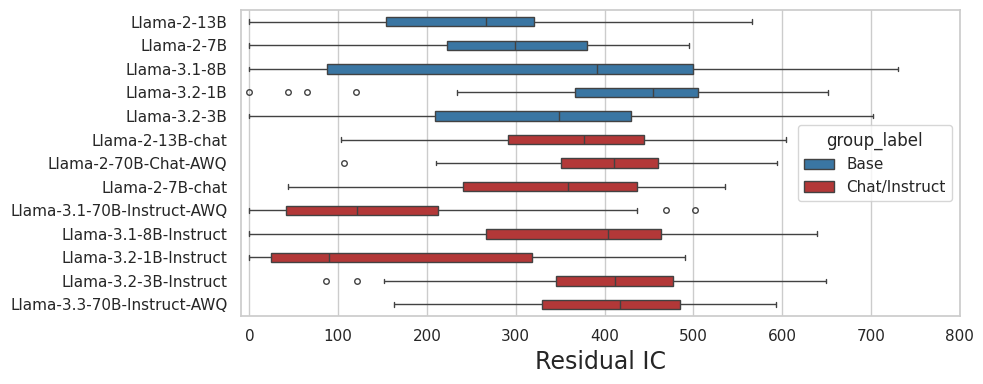

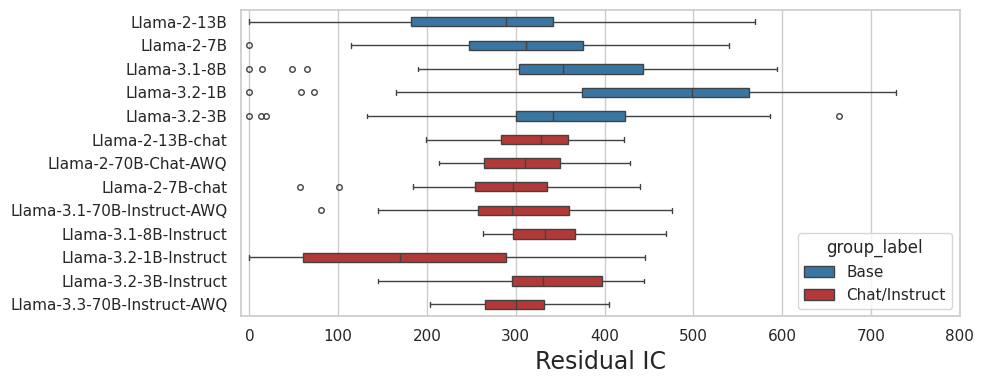

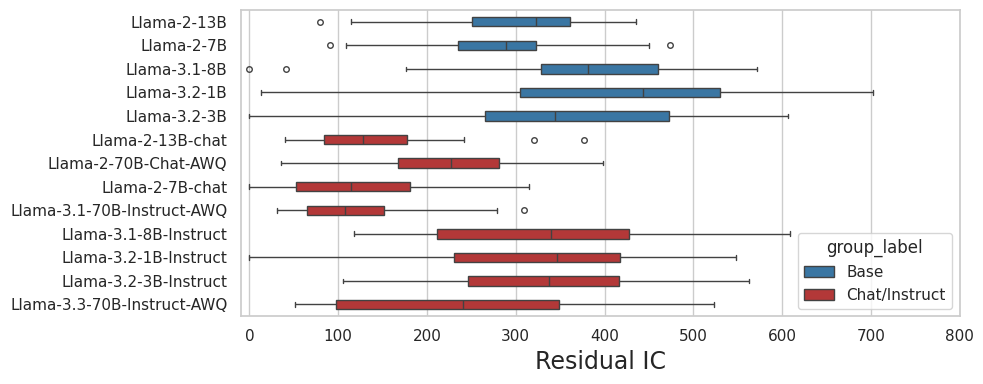

In [84]:

def f(style):
    all_data = []
    FOLDER_PATH = 'processed_results' 
    VALUE_COLUMN_NAME = str(style)+'_residual_info' 
    # Get all csv files in the folder
    csv_files = glob.glob(os.path.join(FOLDER_PATH, "*info.csv"))
    
    print(f"Found {len(csv_files)} files. Processing...")
    for file_path in csv_files:
        # Get filename without extension to use as the label
        file_name = os.path.basename(file_path)
        label_name = os.path.splitext(file_name)[0]
        label_name= re.sub("_residual_info",'',label_name)
        print(label_name)
        keywords = ["chat", "Chat", "Instruct"]
        if any(k in label_name for k in keywords):
            group_label = "Chat/Instruct"
        else:
            group_label = "Base"
    
        try:
            # Read the CSV
            df = pd.read_csv(file_path)
            
            # Check if the target column exists
            if VALUE_COLUMN_NAME in df.columns:
                # extract the values and create a temporary dataframe
                temp_df = pd.DataFrame({
                    'Score': df[VALUE_COLUMN_NAME],
                    'Question Types': label_name,
                    'group_label':group_label
                })
                all_data.append(temp_df)
            else:
                print(f"Warning: Column '{VALUE_COLUMN_NAME}' not found in {file_name}")
                
        except Exception as e:
            print(f"Error reading {file_name}: {e}")
    
    
    final_df = pd.concat(all_data, ignore_index=True)
    final_df = final_df.sort_values(by=['group_label', 'Question Types'], ascending=[True, True])
    sorted_order = final_df['Question Types'].unique()
    
    # --- PLOTTING ---
    
    # Set the visual style to match the image (white background with grid)
    sns.set_theme(style="whitegrid")
    
    # Initialize the figure size
    plt.figure(figsize=(10, 4))
    
    # Create the Boxplot
    # orient='h' ensures it is horizontal
    sns.boxplot(
        data=final_df,
        x='Score',
        y='Question Types',
        order= sorted_order,
        hue='group_label',
        palette=["#2878B5", "#C82423"],  # A standard matplotlib blue color
        width=0.4,        # Adjusts the width of the boxes
        fliersize=4       # Size of the diamond outliers
    )
    
    # Customizing Labels and Limits
    plt.xlabel("Residual IC", fontsize=17)
    plt.ylabel("", fontsize=20)
    plt.xlim(-10, 800) # Assuming scores are between 0 and 1
    
    # Tweak layout to prevent label clipping
    plt.tight_layout()
    
    # Show or Save
    #plt.show()
    plt.savefig(str(style)+'_chat_base_residual_info.png',dpi=300) # Uncomment to save

for style in ["academic","oral","twitter"]:
    f(style)




Found 13 files. Processing...
Llama-2-13B-chat
Llama-2-7B
Llama-3.2-1B
Llama-3.2-3B
Llama-3.2-1B-Instruct
Llama-3.1-8B
Llama-2-70B-Chat-AWQ
Llama-3.1-70B-Instruct-AWQ
Llama-3.1-8B-Instruct
Llama-3.3-70B-Instruct-AWQ
Llama-2-13B
Llama-3.2-3B-Instruct
Llama-2-7B-chat
Found 13 files. Processing...
Llama-2-13B-chat
Llama-2-7B
Llama-3.2-1B
Llama-3.2-3B
Llama-3.2-1B-Instruct
Llama-3.1-8B
Llama-2-70B-Chat-AWQ
Llama-3.1-70B-Instruct-AWQ
Llama-3.1-8B-Instruct
Llama-3.3-70B-Instruct-AWQ
Llama-2-13B
Llama-3.2-3B-Instruct
Llama-2-7B-chat
Found 13 files. Processing...
Llama-2-13B-chat
Llama-2-7B
Llama-3.2-1B
Llama-3.2-3B
Llama-3.2-1B-Instruct
Llama-3.1-8B
Llama-2-70B-Chat-AWQ
Llama-3.1-70B-Instruct-AWQ
Llama-3.1-8B-Instruct
Llama-3.3-70B-Instruct-AWQ
Llama-2-13B
Llama-3.2-3B-Instruct
Llama-2-7B-chat


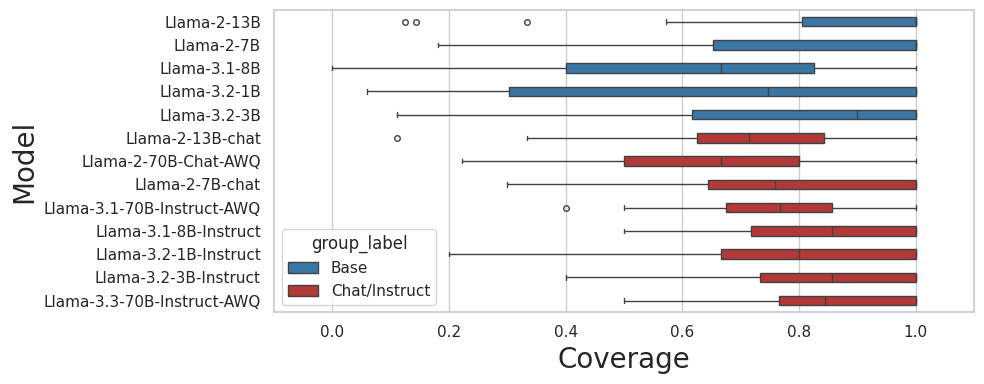

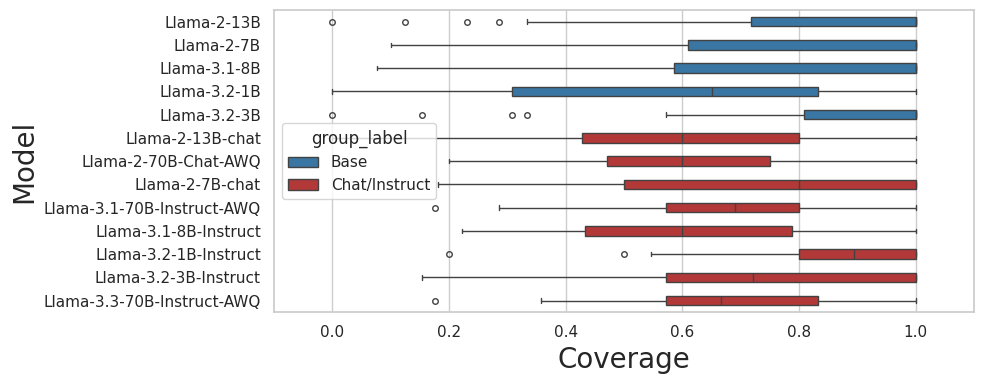

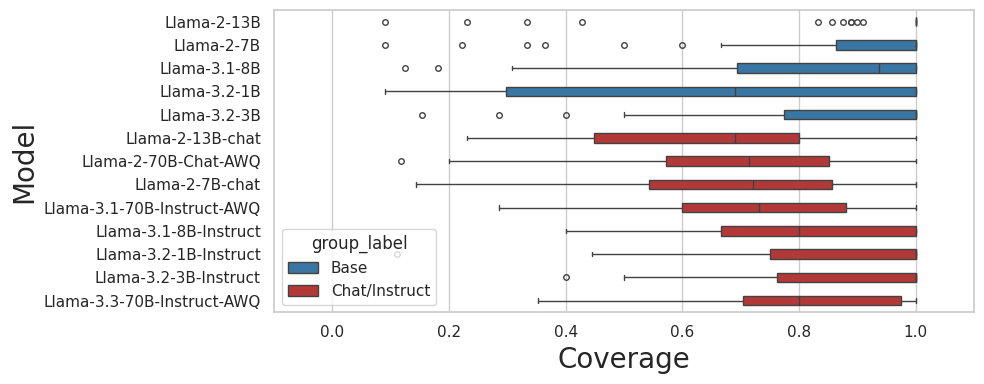

In [85]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import glob
import re
def f(style):
    # --- CONFIGURATION (MODIFY THESE) ---
    # 1. Path to your folder containing the CSV files
    FOLDER_PATH = 'processed_results' 
    
    # 2. The name of the column in your CSVs that contains the numbers to plot
    # (e.g., 'f1', 'score', 'accuracy', 'value')
    VALUE_COLUMN_NAME = style+'_coverage' 
    
    all_data = []
    
    # Get all csv files in the folder
    csv_files = glob.glob(os.path.join(FOLDER_PATH, "*coverage.csv"))
    
    
    print(f"Found {len(csv_files)} files. Processing...")
    
    for file_path in csv_files:
        # Get filename without extension to use as the label
        file_name = os.path.basename(file_path)
        label_name = os.path.splitext(file_name)[0]
        label_name= re.sub("_coverage",'',label_name)
        print(label_name)
        keywords = ["chat", "Chat", "Instruct"]
        if any(k in label_name for k in keywords):
            group_label = "Chat/Instruct"
        else:
            group_label = "Base"
        try:
            # Read the CSV
            df = pd.read_csv(file_path)
            
            # Check if the target column exists
            if VALUE_COLUMN_NAME in df.columns:
                # extract the values and create a temporary dataframe
                temp_df = pd.DataFrame({
                    'Score': df[VALUE_COLUMN_NAME],
                    'Question Types': label_name,
                    'group_label':group_label
                })
                all_data.append(temp_df)
            else:
                print(f"Warning: Column '{VALUE_COLUMN_NAME}' not found in {file_name}")
                
        except Exception as e:
            print(f"Error reading {file_name}: {e}")
    
    final_df = pd.concat(all_data, ignore_index=True)
    final_df = final_df.sort_values(by=['group_label', 'Question Types'], ascending=[True, True])
    sorted_order = final_df['Question Types'].unique()
    # --- PLOTTING ---
    
    # Set the visual style to match the image (white background with grid)
    sns.set_theme(style="whitegrid")
    
    # Initialize the figure size
    plt.figure(figsize=(10, 4))
    
    # Create the Boxplot
    # orient='h' ensures it is horizontal
    sns.boxplot(
        data=final_df,
        x='Score',
        y='Question Types',
        hue='group_label',
        order= sorted_order,
        palette=["#2878B5", "#C82423"],  # A standard matplotlib blue color
        width=0.4,        # Adjusts the width of the boxes
        fliersize=4       # Size of the diamond outliers
    )
    
    # Customizing Labels and Limits
    plt.xlabel("Coverage", fontsize=20)
    plt.ylabel("Model", fontsize=20)
    plt.xlim(-0.1, 1.1) # Assuming scores are between 0 and 1
    
    # Tweak layout to prevent label clipping
    plt.tight_layout()
    
    # Show or Save
    #plt.show()
    plt.savefig(style+'_coverage.png',dpi=300) # Uncomment to save
for style in ["academic","oral","twitter"]:
    f(style)
